In [ ]:
from ngsolve import *
#from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def matvec_b(v):
    tmp1.data = v
    tmp2.data = b * tmp1
    return tmp2.FV().NumPy()


def matvec_c(v):
    tmp3.data = v
    tmp4.data = c.mat * tmp3
    return tmp4.FV().NumPy()


#l is number of meshwidths, the n-th meshwidth is 1/(2^(n-1))
l = 4
meshwidths = np.ones(l)
for h in range(l-1):
    meshwidths[h+1] = meshwidths[h]/2

print(meshwidths)
#order for which the elements corresponds to the whitney forms H1,HCurl = 1, HDiv = 0
lowest_low_order = 0
# amount of orders for the low-Order space (set to 1 if not interested in higher low orders)
low_orders = 1
# largest low order to test
highest_low_order = lowest_low_order + low_orders

#amount of orders for the high-Order space
high_orders = 3 
#array storing the minimal Eigenvalue for given orders and meshwidth
minEV = np.zeros((low_orders,high_orders,l))

for j in range(lowest_low_order , highest_low_order):
    #high order needs to be greater than low order
    lowest_high_Order = j + 1
    #largest high order to test
    highest_high_order = lowest_high_Order + high_orders
    for i in range(lowest_high_Order, highest_high_order):
        #reset mesh for new high Order
        netgen_mesh =unit_square.GenerateMesh(maxh=1)
        mesh=Mesh(netgen_mesh)

        print("polynomal order of low order space:", j, ", polynomal order of high order space:", i)
        for k in range(l):
            print("h=",meshwidths[k], "\n")
            #Draw(mesh)

            #set function space, for l=1 its edge conforming H(Div) Elements
            #need to compress to remove DOFs of unrefined mesh after refinement
            H_h = Compress(HDiv(mesh, order = j, RT=True, complex=False)) # main function space
            w_h = GridFunction(H_h) #define vector for matvec wrapper
            H_H = Compress(HDiv(mesh, order = i, RT=True, complex=False)) # high order Function space for Riesz representative  

            print("# DoFs of low order space:", H_h.ndof, ", # DoFs of high order space:", H_H.ndof)

            #low order
            u_h = H_h.TrialFunction() # define the trial function
            v_h = H_h.TestFunction() # define the test function
            #High order
            u_H = H_H.TrialFunction() # define the trial function
            v_H= H_H.TestFunction() # define the test function

            m = BilinearForm(H_h, symmetric=True, symmetric_storage=True) #define m with the L2 inner product on the low order space
            m += u_h*v_h * dx 
            m.Assemble()

            a = BilinearForm(H_H, symmetric=True, symmetric_storage=True) # define the H(Div) inner product on the high order space
            a += div(u_H) * div(v_H) * dx
            a += u_H*v_H * dx 
            a.Assemble()

            #mass matrix with mixed basis functions
            a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
            a_mixed += u_h*v_H*dx
            a_mixed.Assemble()

            #compute inverses 
            a_inv = a.mat.Inverse(inverse="sparsecholesky")
            m_inv = m.mat.Inverse(inverse="sparsecholesky")

            #create Matrices for GEV problem

            #c is the low order galerkin matrix
            c = BilinearForm(H_h, symmetric=True, symmetric_storage=True)
            c += div(u_h) * div(v_h) * dx
            c += u_h*v_h * dx 
            c.Assemble()

            # b is the Matrix that lets us compute the norm of the Riesz representative
            # m==m.t, m_inv == m_inv.T
            b = c.mat.T @m_inv @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_inv @ c.mat

            tmp1 = w_h.vec.CreateVector()
            tmp2 = w_h.vec.CreateVector()

            tmp3 = w_h.vec.CreateVector()
            tmp4 = w_h.vec.CreateVector()

            B = sp.sparse.linalg.LinearOperator((b.height,b.width), matvec_b)
            C = sp.sparse.linalg.LinearOperator((c.mat.height,c.mat.width), matvec_c)   

            #The matrices Involved are Symmetric, so the symmetric solver is used
            #look for largest Eigenvalue of Bx = λCx, since ARPACK is more efficient for large EV's
            lam = sp.sparse.linalg.eigsh(B, k=1, M=C, which='LM', return_eigenvectors=False)
            print(lam)
            #if FEM space is complex need to take absolut value (the EV's have no imaginary part, but are still datatype complex)        
            #lam = np.abs(lam)
            #1/λ is the smallest EV of Cx = λBX
            minEV[j-lowest_low_order,i-lowest_high_Order,k] = 1/lam[0]

            #uniformly refines mesh, halving meshwidth
            mesh.Refine()
            print("\n")

print(minEV)

[1.    0.5   0.25  0.125]
polynomal order of low order space: 1 , polynomal order of high order space: 2
h= 1.0 

# DoFs of low order space: 5 , # DoFs of high order space: 14
[1.]


h= 0.5 

# DoFs of low order space: 16 , # DoFs of high order space: 48
[1.]


h= 0.25 

# DoFs of low order space: 56 , # DoFs of high order space: 176
[1.]


h= 0.125 

# DoFs of low order space: 208 , # DoFs of high order space: 672
[1.]


polynomal order of low order space: 1 , polynomal order of high order space: 3
h= 1.0 

# DoFs of low order space: 5 , # DoFs of high order space: 27
[1.]


h= 0.5 

# DoFs of low order space: 16 , # DoFs of high order space: 96
[1.]


h= 0.25 

# DoFs of low order space: 56 , # DoFs of high order space: 360
[1.]


h= 0.125 

# DoFs of low order space: 208 , # DoFs of high order space: 1392
[1.]


polynomal order of low order space: 1 , polynomal order of high order space: 4
h= 1.0 

# DoFs of low order space: 5 , # DoFs of high order space: 44
[1.]


h= 0.5 

# DoFs 

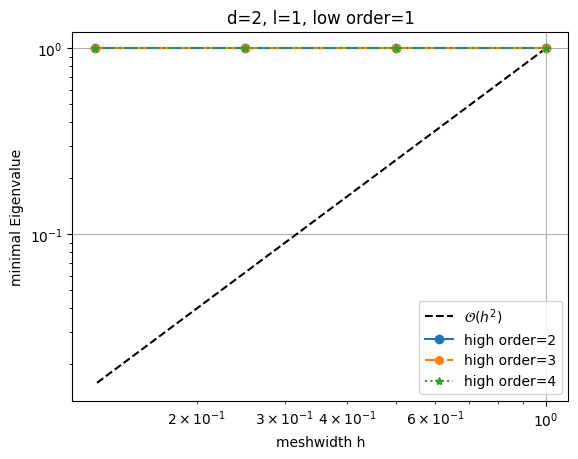

In [6]:

symbols = ['o-','h-.','*:','+-']

for j in range(lowest_low_order, highest_low_order):
    fig, ax = plt.subplots()
    plt.grid(visible=True)
    plt.title(label="d=2, l=1, low order=%i" %j)
    plt.xlabel('meshwidth h')
    plt.ylabel('minimal Eigenvalue')
    plt.loglog(meshwidths,np.power(meshwidths,2),'--k', label=r'$\mathcal{O}(h^{2})$')

    lowest_high_Order = j + 1
    highest_high_order = lowest_high_Order + high_orders
    for i in range(lowest_high_Order,highest_high_order):
        plt.loglog(meshwidths,minEV[j-lowest_low_order,i-lowest_high_Order,:], symbols[i-lowest_high_Order], label="high order=%i"%i)

    plt.legend()
    plt.show()
